In [94]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import wer
from sklearn.linear_model import LinearRegression, RANSACRegressor

# Apply the default theme
sns.set_theme()

In [95]:
df = pd.DataFrame()
for path in glob.glob("./../networks_test/*"):
    df_tmp = pd.read_csv(path + "/transcriptions.csv")
    # df_tmp = df.set_index('ground_truth', drop=True)
    if len(df)==0:
        df = df_tmp[:]
    else:
        df = df.merge(df_tmp, on="ground_truth")
    
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()


,speechbrain/asr-crdnn-rnnlm-librispeech,speechbrain/asr-crdnn-rnnlm-librispeech_inf_time,ground_truth,facebook/s2t-large-librispeech-asr,facebook/s2t-large-librispeech-asr_inf_time,facebook/wav2vec2-large-960h-lv60-self,facebook/wav2vec2-large-960h-lv60-self_inf_time,deepspeech-0.9.3-models.pbmm_Beam_10,deepspeech-0.9.3-models.pbmm_Beam_10_inf_time,deepspeech-0.9.3-models.pbmm_Beam_25,deepspeech-0.9.3-models.pbmm_Beam_25_inf_time,deepspeech-0.9.3-models.pbmm_Beam_50,deepspeech-0.9.3-models.pbmm_Beam_50_inf_time,deepspeech-0.9.3-models.pbmm_Beam_100,deepspeech-0.9.3-models.pbmm_Beam_100_inf_time,deepspeech-0.9.3-models.pbmm_Beam_200,deepspeech-0.9.3-models.pbmm_Beam_200_inf_time,deepspeech-0.9.3-models.pbmm_Beam_500,deepspeech-0.9.3-models.pbmm_Beam_500_inf_time
0,A MAN SAID TO THE UNIVERSE SIR I EXIST,7.215630,A MAN SAID TO THE UNIVERSE SIR I EXIST,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.873919,A MAN SAID TO THE UNIVERSE SIR I EXIST,5.198802,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.606754,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.702314,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.615516,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.635030,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.687241,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.736053
1,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,21.831181,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,3.680889,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,6.495734,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,3.665738,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,3.802648,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,3.701198,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,3.706243,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,3.715013,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,3.881920
2,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,29.324319,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,7.644466,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,14.213657,THE COON HIS CHEST STILL DRIPPING BLOOD THE AC...,7.583652,THE COON HIS CHEST STILL DRIPPING BLOOD THE AC...,7.810050,THE CANON HIS CHEST STILL DRIPPING BLOOD THE A...,7.600449,THE CANON HIS CHEST STILL DRIPPING BLOOD THE A...,7.668546,THE CANON HIS CHEST STILL DRIPPING BLOOD THE A...,7.676841,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,8.073133
3,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,10.128328,HIS INSTANT OF PANIC WAS FOLLOWED BY A SMALL S...,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,3.364908,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,5.510652,MISTESSES FOLLOWED BY A SMALL SHARP BLOW HIGH ...,3.078627,MISTASSINNI WAS FOLLOWED BY A SMALL SHARP BLOW...,3.196123,STISTICK WAS FOLLOWED BY A SMALL SHARP BLOW HI...,3.111215,I TINTENIAC WAS FOLLOWED BY A SMALL SHARP BLOW...,3.158297,I TITANIC WAS FOLLOWED BY A SMALL SHARP BLOW H...,3.116670,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,3.282702
4,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,7.656298,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,ONE MINUTE A VOICE SAID AND A TIME BUZZER SOUNDED,2.906659,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,5.017462,ONE MINUTE A VOICE SAID AND THE TIME WAS OUR S...,2.958937,ONE MINUTE A VOICE SAID AND THE TIME WAS OUR S...,3.027381,ONE MINUTE A VOICE SAID AND THE TIME WAS OUR S...,2.939013,ONE MINUTE A VOICE SAID AND THE TIME WAS OUR S...,3.067086,ONE MINUTE A VOICE SAID AND THE TIME WAS OUR S...,2.978702,ONE MINUTE A VOICE SAID AND THE TIME WAS OUR S...,3.105220


In [96]:
networks = [
    'speechbrain/asr-crdnn-rnnlm-librispeech',
    'facebook/s2t-large-librispeech-asr',
    'facebook/wav2vec2-large-960h-lv60-self',
    'deepspeech-0.9.3-models.pbmm_Beam_10',
    'deepspeech-0.9.3-models.pbmm_Beam_25',
    'deepspeech-0.9.3-models.pbmm_Beam_50',
    'deepspeech-0.9.3-models.pbmm_Beam_100',
    'deepspeech-0.9.3-models.pbmm_Beam_200',
    'deepspeech-0.9.3-models.pbmm_Beam_500',
]

for col in df[networks]:
    df[col+"_wer"] = df[df.columns[~df.columns.str.contains('inf_time')]].apply(lambda x: wer(x['ground_truth'], x[col]), axis=1)
df.head()

,speechbrain/asr-crdnn-rnnlm-librispeech,speechbrain/asr-crdnn-rnnlm-librispeech_inf_time,ground_truth,facebook/s2t-large-librispeech-asr,facebook/s2t-large-librispeech-asr_inf_time,facebook/wav2vec2-large-960h-lv60-self,facebook/wav2vec2-large-960h-lv60-self_inf_time,deepspeech-0.9.3-models.pbmm_Beam_10,deepspeech-0.9.3-models.pbmm_Beam_10_inf_time,deepspeech-0.9.3-models.pbmm_Beam_25,...,deepspeech-0.9.3-models.pbmm_Beam_500_inf_time,speechbrain/asr-crdnn-rnnlm-librispeech_wer,facebook/s2t-large-librispeech-asr_wer,facebook/wav2vec2-large-960h-lv60-self_wer,deepspeech-0.9.3-models.pbmm_Beam_10_wer,deepspeech-0.9.3-models.pbmm_Beam_25_wer,deepspeech-0.9.3-models.pbmm_Beam_50_wer,deepspeech-0.9.3-models.pbmm_Beam_100_wer,deepspeech-0.9.3-models.pbmm_Beam_200_wer,deepspeech-0.9.3-models.pbmm_Beam_500_wer
0,A MAN SAID TO THE UNIVERSE SIR I EXIST,7.215630,A MAN SAID TO THE UNIVERSE SIR I EXIST,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.873919,A MAN SAID TO THE UNIVERSE SIR I EXIST,5.198802,A MAN SAID TO THE UNIVERSE SIR I EXIST,2.606754,A MAN SAID TO THE UNIVERSE SIR I EXIST,...,2.736053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,21.831181,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,3.680889,SWEAT COVERED BRION'S BODY TRICKLING INTO THE ...,6.495734,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,3.665738,SWEAT COVERED BRIAN'S BODY TRICKLING INTO THE ...,...,3.881920,0.312500,0.187500,0.125000,0.625000,0.250000,0.250000,0.250000,0.250000,0.250000
2,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,29.324319,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,7.644466,THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ...,14.213657,THE COON HIS CHEST STILL DRIPPING BLOOD THE AC...,7.583652,THE COON HIS CHEST STILL DRIPPING BLOOD THE AC...,...,8.073133,0.064516,0.032258,0.000000,0.193548,0.161290,0.161290,0.129032,0.129032,0.064516
3,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,10.128328,HIS INSTANT OF PANIC WAS FOLLOWED BY A SMALL S...,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,3.364908,HIS INSTANT PANIC WAS FOLLOWED BY A SMALL SHAR...,5.510652,MISTESSES FOLLOWED BY A SMALL SHARP BLOW HIGH ...,3.078627,MISTASSINNI WAS FOLLOWED BY A SMALL SHARP BLOW...,...,3.282702,0.066667,0.066667,0.066667,0.333333,0.266667,0.266667,0.266667,0.266667,0.066667
4,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,7.656298,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,ONE MINUTE A VOICE SAID AND A TIME BUZZER SOUNDED,2.906659,ONE MINUTE A VOICE SAID AND THE TIME BUZZER SO...,5.017462,ONE MINUTE A VOICE SAID AND THE TIME WAS OUR S...,2.958937,ONE MINUTE A VOICE SAID AND THE TIME WAS OUR S...,...,3.105220,0.000000,0.100000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000


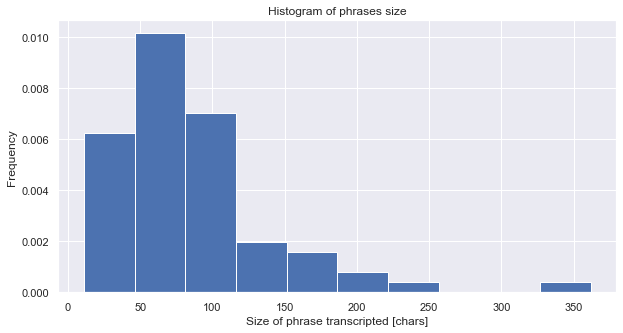

In [97]:
plt.figure(figsize=(10,5))
plt.hist(df['ground_truth'].str.len(), density=True)
plt.title("Histogram of phrases size")
plt.ylabel("Frequency")
plt.xlabel("Size of phrase transcripted [chars]")
plt.savefig('./graphs/histogram_phrase.png')
plt.show()


#chars = 6.2 * inf_time 0.9 for speechbrain/asr-crdnn-rnnlm-librispeech_inf_time
#chars = 26.3 * inf_time -6.1 for facebook/s2t-large-librispeech-asr_inf_time
#chars = 14.0 * inf_time -7.3 for facebook/wav2vec2-large-960h-lv60-self_inf_time
#chars = 21.6 * inf_time -3.1 for deepspeech-0.9.3-models.pbmm_Beam_500_inf_time


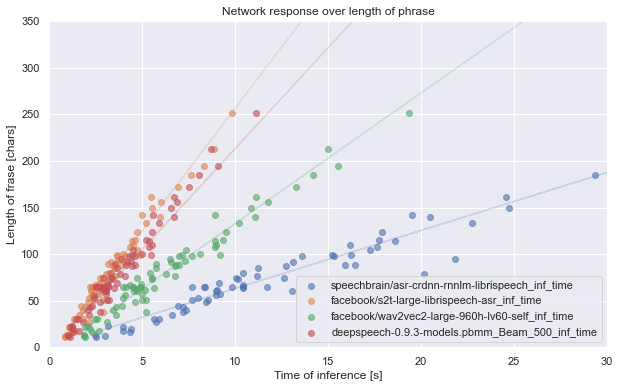

In [98]:
networks = [
    'speechbrain/asr-crdnn-rnnlm-librispeech',
    'facebook/s2t-large-librispeech-asr',
    'facebook/wav2vec2-large-960h-lv60-self',
    # 'deepspeech-0.9.3-models.pbmm_Beam_100',
    # 'deepspeech-0.9.3-models.pbmm_Beam_250',
    'deepspeech-0.9.3-models.pbmm_Beam_500',
]

plt.figure(figsize=(10,6))



for col_name in networks:
    col = col_name + "_inf_time"
    X = df[col].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = df['ground_truth'].str.len().values.reshape(-1)  # -1 means that calculate the dimension of rows, but have 1 column
    robustreg = RANSACRegressor()  # create object for the class
    robustreg.fit(X, Y)  # perform linear regression
    Y_pred = robustreg.predict(X)  # make predictions
    plt.scatter(X, Y, label=col, alpha=0.6,)
    plt.plot(X, Y_pred, alpha=0.2, linewidth=1,)
    print("#chars = {:.1f} * inf_time {:.1f} for {}".format(robustreg.estimator_.coef_[0], robustreg.estimator_.intercept_, col))

plt.legend()
plt.title("Network response over length of phrase")
plt.xlabel("Time of inference [s]")
plt.ylabel("Length of frase [chars]")
plt.legend()
plt.xlim([0, 30])
plt.ylim([0, 350])
plt.savefig('./graphs/network_response.png')
plt.show()


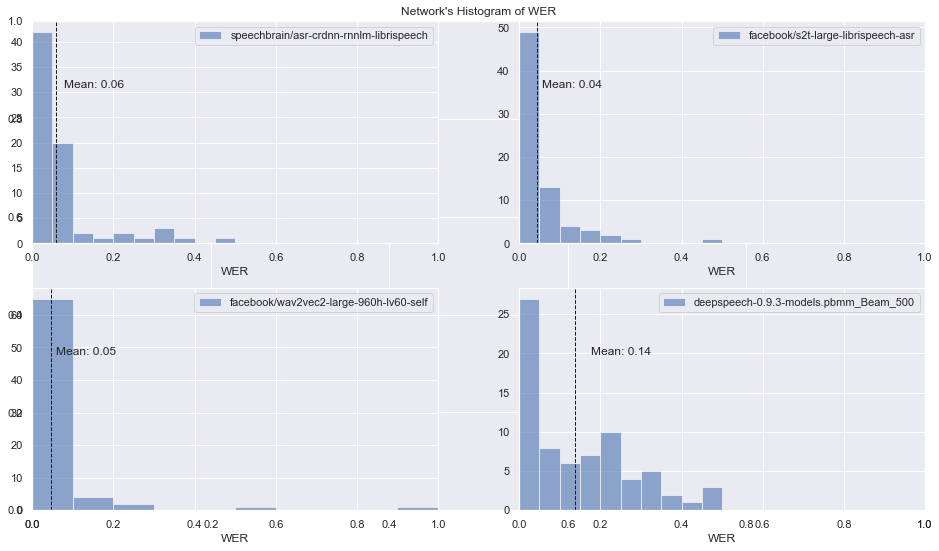

In [99]:
networks = [
    'speechbrain/asr-crdnn-rnnlm-librispeech',
    'facebook/s2t-large-librispeech-asr',
    'facebook/wav2vec2-large-960h-lv60-self',
    # 'deepspeech-0.9.3-models.pbmm_Beam_100',
    # 'deepspeech-0.9.3-models.pbmm_Beam_250',
    'deepspeech-0.9.3-models.pbmm_Beam_500',
]

fig = plt.figure(figsize=(16,9))
plt.title("Network's Histogram of WER")

for i, col in enumerate(networks):

    Y = df[col+"_wer"].values.reshape(-1, 1)  

    fig.add_subplot(2,2,i+1)

    plt.hist(Y, alpha=0.6, label=col, bins=10)
    plt.axvline(Y.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(Y.mean()*1.3, max_ylim*0.7, 'Mean: {:.2f}'.format(Y.mean()))

    plt.legend()
    plt.xlim([0, 1])
    plt.xlabel("WER")
plt.savefig('./graphs/histogram_wer.png')
plt.show()


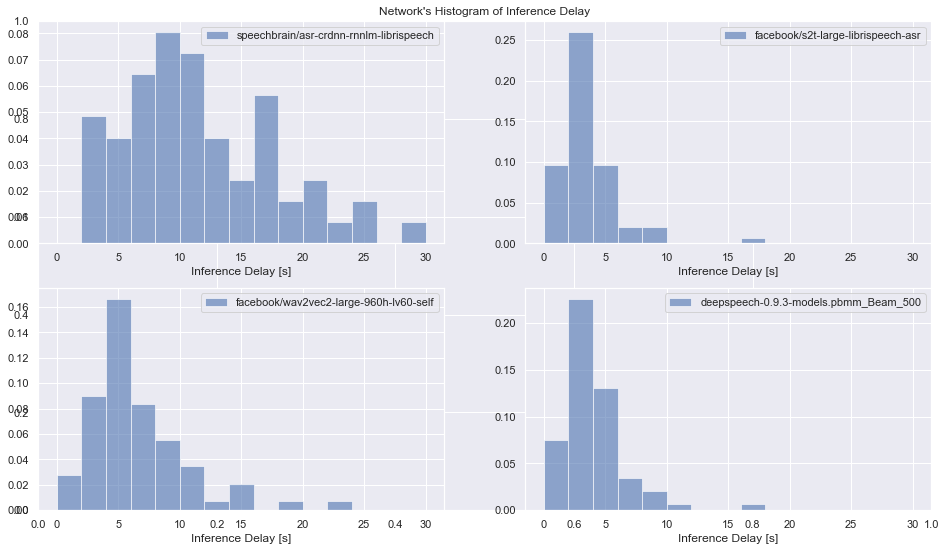

In [100]:
networks = [
    'speechbrain/asr-crdnn-rnnlm-librispeech',
    'facebook/s2t-large-librispeech-asr',
    'facebook/wav2vec2-large-960h-lv60-self',
    # 'deepspeech-0.9.3-models.pbmm_Beam_100',
    # 'deepspeech-0.9.3-models.pbmm_Beam_250',
    'deepspeech-0.9.3-models.pbmm_Beam_500',
]

fig = plt.figure(figsize=(16,9))
plt.title("Network's Histogram of Inference Delay")

for i, col in enumerate(networks):

    Y = df[col+"_inf_time"].values.reshape(-1, 1)  

    fig.add_subplot(2,2,i+1)

    plt.hist(Y, alpha=0.6, label=col, density=True, bins=15, range=(0, 30))
    # plt.axvline(Y.mean(), color='k', linestyle='dashed', linewidth=1)
    # min_ylim, max_ylim = plt.ylim()
    # plt.text(Y.mean()*1.3, max_ylim*0.7, 'Mean: {:.2f}'.format(Y.mean()))

    plt.legend()
    plt.xlabel("Inference Delay [s]")
plt.savefig('./graphs/histogram_delay.png')
plt.show()


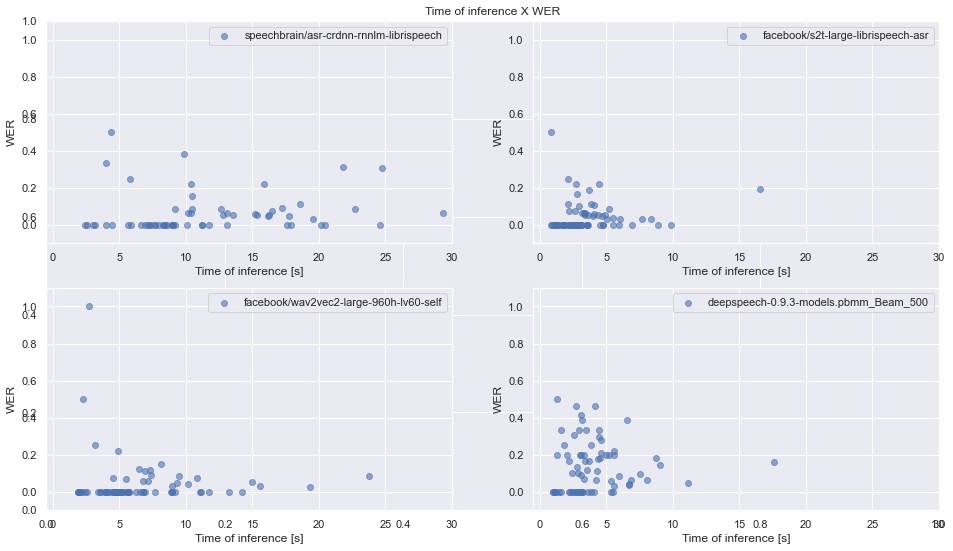

In [101]:
fig = plt.figure(figsize=(16,9))
plt.title("Time of inference X WER")

for i, col in enumerate(networks):

    X = df[col+"_inf_time"].values.reshape(-1, 1)  
    Y = df[col+"_wer"].values.reshape(-1, 1) 

    fig.add_subplot(2,2,i+1)
    plt.scatter(X,Y, label=col, alpha=0.6)
    
    plt.legend()
    plt.ylim([-0.1, 1.1])
    plt.xlim([-0.5, 30])
    plt.ylabel("WER")
    plt.xlabel("Time of inference [s]")
plt.savefig('./graphs/inf_time_x_wer.png')
plt.show()


## Optitimization of Beam Search hyperparameter

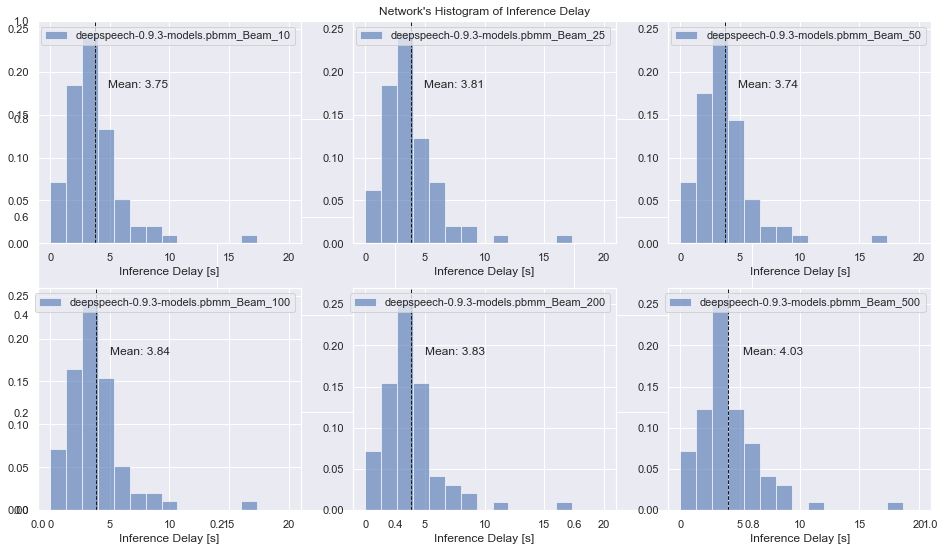

In [102]:
networks = [
    'deepspeech-0.9.3-models.pbmm_Beam_10',
    'deepspeech-0.9.3-models.pbmm_Beam_25',
    'deepspeech-0.9.3-models.pbmm_Beam_50',
    'deepspeech-0.9.3-models.pbmm_Beam_100',
    'deepspeech-0.9.3-models.pbmm_Beam_200',
    'deepspeech-0.9.3-models.pbmm_Beam_500',
]

fig = plt.figure(figsize=(16,9))
plt.title("Network's Histogram of Inference Delay")

for i, col in enumerate(networks):

    Y = df[col+"_inf_time"].values.reshape(-1, 1)  

    fig.add_subplot(2,3,i+1)

    plt.hist(Y, alpha=0.6, label=col, density=True, bins=15, range=(0, 20))
    plt.axvline(Y.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(Y.mean()*1.3, max_ylim*0.7, 'Mean: {:.2f}'.format(Y.mean()))


    plt.legend()
    plt.xlabel("Inference Delay [s]")
plt.savefig('./graphs/inf_delay_beamsearch.png')
plt.show()


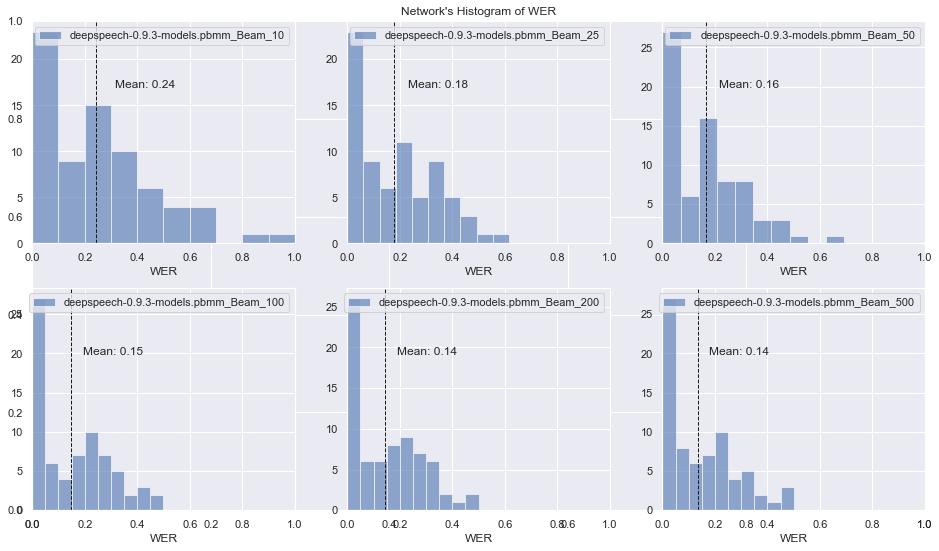

In [103]:
fig = plt.figure(figsize=(16,9))
plt.title("Network's Histogram of WER")

for i, col in enumerate(networks):

    Y = df[col+"_wer"].values.reshape(-1, 1)  

    fig.add_subplot(2,3,i+1)

    plt.hist(Y, alpha=0.6, label=col, bins=10)
    plt.axvline(Y.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(Y.mean()*1.3, max_ylim*0.7, 'Mean: {:.2f}'.format(Y.mean()))

    plt.legend()
    plt.xlim([0, 1])
    plt.xlabel("WER")
plt.savefig('./graphs/wer_beamsearch.png')
plt.show()

In [104]:
# fig = plt.figure(figsize=(16,9))
# plt.title("Time of inference X WER")

# for i, col in enumerate(networks):

#     X = df[col+"_inf_time"].values.reshape(-1, 1)  
#     Y = df[col+"_wer"].values.reshape(-1, 1) 

#     fig.add_subplot(2,3,i+1)
#     plt.scatter(X,Y, label=col, alpha=0.6)
    
#     plt.legend()
#     plt.ylim([-0.1, 1.1])
#     plt.xlim([-0.5, 30])
#     plt.ylabel("WER")
#     plt.xlabel("Time of inference [s]")
# # plt.savefig('./graphs/inf_time_x_wer.png')
# plt.show()